In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import tensorflow as tf
import pickle
from pathlib import Path
from dataclasses import dataclass
from mbeml.constants import LigandFeatures, TargetProperty
from mbeml.featurization import data_prep
from mbeml.plotting import color_dict, marker_dict, core_legend, scatter_random_z

In [2]:
plt.style.use("mbeml.mbeml")

In [3]:
data_dir = Path("../../data/")

df_train = pd.read_csv(data_dir / "training_data.csv")
df_val = pd.read_csv(data_dir / "validation_data.csv")

model_dir = Path("../../models/")

In [4]:
@dataclass
class Experiment:
    name: str
    features: LigandFeatures
    target: TargetProperty = TargetProperty.SSE
    is_nn: bool = False
    prediction_train = np.zeros(len(df_train))
    prediction_val = np.zeros(len(df_val))

In [5]:
experiments = [
    Experiment("krr_standard_racs", features=LigandFeatures.STANDARD_RACS),
    Experiment("krr_two_body", features=LigandFeatures.LIGAND_RACS),
    Experiment("krr_three_body", features=LigandFeatures.LIGAND_RACS),
    Experiment("nn_standard_racs", features=LigandFeatures.STANDARD_RACS, is_nn=True),
    Experiment("nn_two_body", features=LigandFeatures.LIGAND_RACS, is_nn=True),
    Experiment("nn_three_body", features=LigandFeatures.LIGAND_RACS, is_nn=True),
]

In [6]:
for experiment in experiments:
    x_train, _ = data_prep(
        df_train, experiment.features, experiment.target, experiment.is_nn
    )
    x_val, _ = data_prep(
        df_val, experiment.features, experiment.target, experiment.is_nn
    )
    # Evaluate model
    if experiment.is_nn:
        model = tf.keras.models.load_model(
            model_dir / experiment.target.name.lower() / experiment.name
        )
        # First element because uncertainty is not needed
        experiment.prediction_train = model.predict(x_train, verbose=0)[0]
        experiment.prediction_val = model.predict(x_val, verbose=0)[0]
    else:
        with open(
            model_dir / experiment.target.name.lower() / f"{experiment.name}.pkl",
            "rb",
        ) as fin:
            model = pickle.load(fin)
        experiment.prediction_train = model.predict(x_train)
        experiment.prediction_val = model.predict(x_val)

2024-02-16 08:20:27.941994: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


# Training set

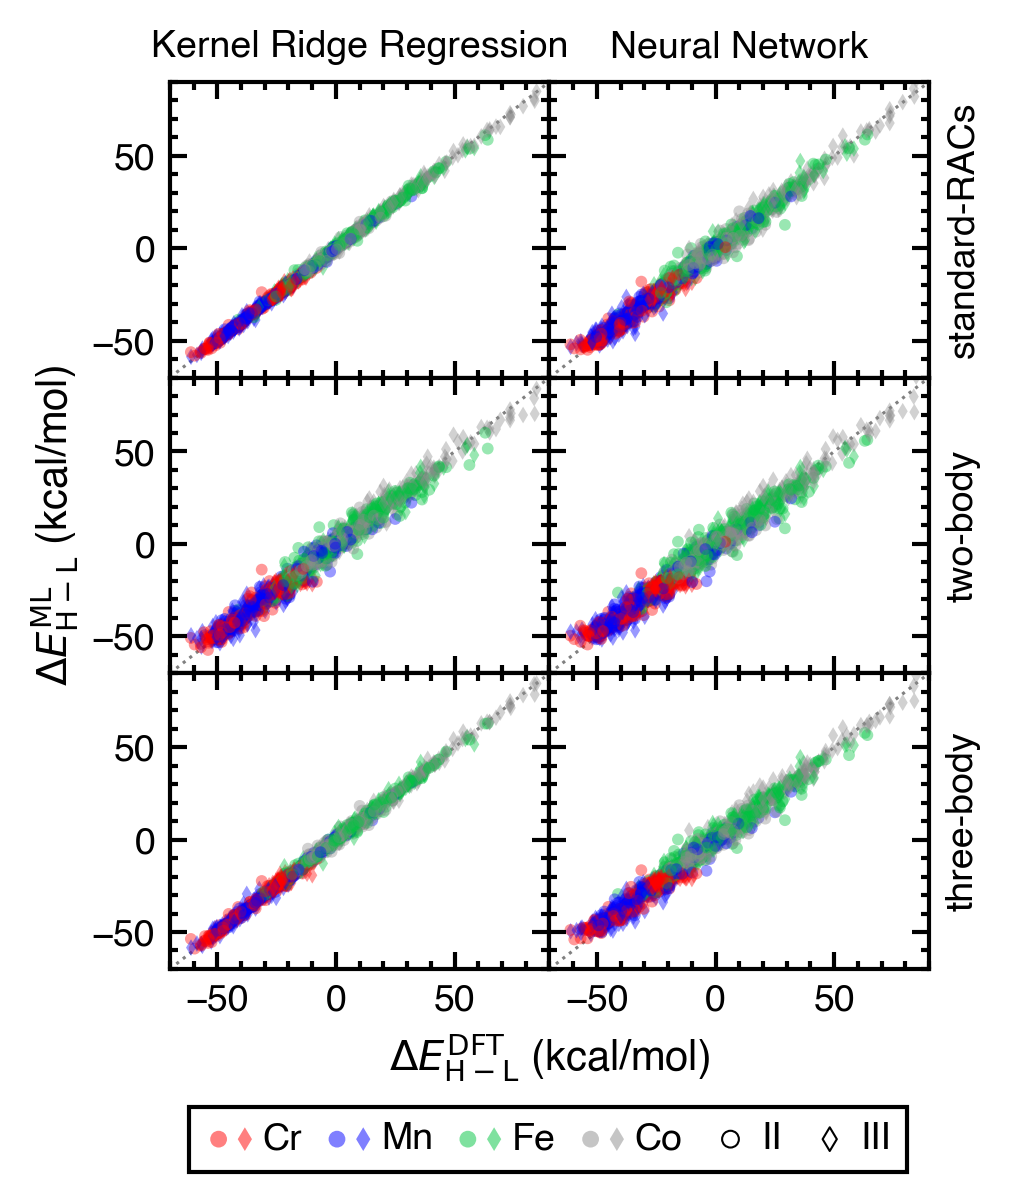

In [7]:
_, y_train = data_prep(
    df_train, LigandFeatures.STANDARD_RACS, TargetProperty.SSE, False
)
cores_train = (
    df_train[["metal", "ox"]].apply(lambda x: f"{x.metal}{x.ox}", axis=1).values
)

figsize = (3.33, 1.2 * 3.33)
fig = plt.figure(figsize=figsize)
gridspec_kw = {
    "left": 0.16,
    "right": 0.92,
    "top": 0.93,
    "bottom": 0.19,
    "hspace": 0.0,
    "wspace": 0.0,
}
axes = fig.subplots(
    ncols=2,
    nrows=3,
    sharex=True,
    sharey=True,
    gridspec_kw=gridspec_kw,
)

scatter_kwargs = {"s": 8, "alpha": 0.4, "edgecolors": "none"}
lower_lim = -70
upper_lim = 90

for experiment, ax in zip(experiments, axes.T.flatten()):
    colors = np.array([color_dict[core[:2]] for core in cores_train])
    markers = np.array([marker_dict[core[-1]] for core in cores_train])
    scatter_random_z(
        ax,
        y_train,
        experiment.prediction_train,
        colors,
        markers,
        **scatter_kwargs,
    )
    # Plot parity line:
    ax.plot(
        [lower_lim, upper_lim],
        [lower_lim, upper_lim],
        color="0.5",
        linewidth=0.75,
        zorder=0.5,
        linestyle=":",
    )
    # Set limits and ticks
    ax.set_xlim([lower_lim, upper_lim])
    ax.set_ylim([lower_lim, upper_lim])
    ax.set_xticks(10 * np.arange(-7, 10), minor=True)
    ax.set_yticks(10 * np.arange(-7, 10), minor=True)

fig.text(
    gridspec_kw["left"] + 0.5 * (gridspec_kw["right"] - gridspec_kw["left"]),
    gridspec_kw["bottom"] - 0.085,
    "$\Delta E^\mathrm{DFT}_{\mathrm{H}-\mathrm{L}}$ (kcal/mol)",
    ha="center",
)
fig.text(
    0.02,
    gridspec_kw["bottom"] + 0.5 * (gridspec_kw["top"] - gridspec_kw["bottom"]),
    "$\Delta E^\mathrm{ML}_{\mathrm{H}-\mathrm{L}}$ (kcal/mol)",
    rotation=90,
    va="center",
)
axes[0, 0].set_title("Kernel Ridge Regression", fontsize=9, y=None)
axes[0, 1].set_title("Neural Network", fontsize=9, y=None)
for i, label in enumerate(["standard-RACs", "two-body", "three-body"]):
    axes[i, 1].set_ylabel(label, fontsize=9)
    axes[i, 1].yaxis.set_label_position("right")

# Legend
core_legend(
    axes[-1, 1],
    legend_kwargs=dict(
        loc="lower left",
        bbox_to_anchor=[-1.0, -0.75],
        markerscale=0.9,
        handletextpad=0.08,
        columnspacing=0.52,
    ),
)

fig.savefig("plots/parity_plot_sse_train.pdf")

# Validation set

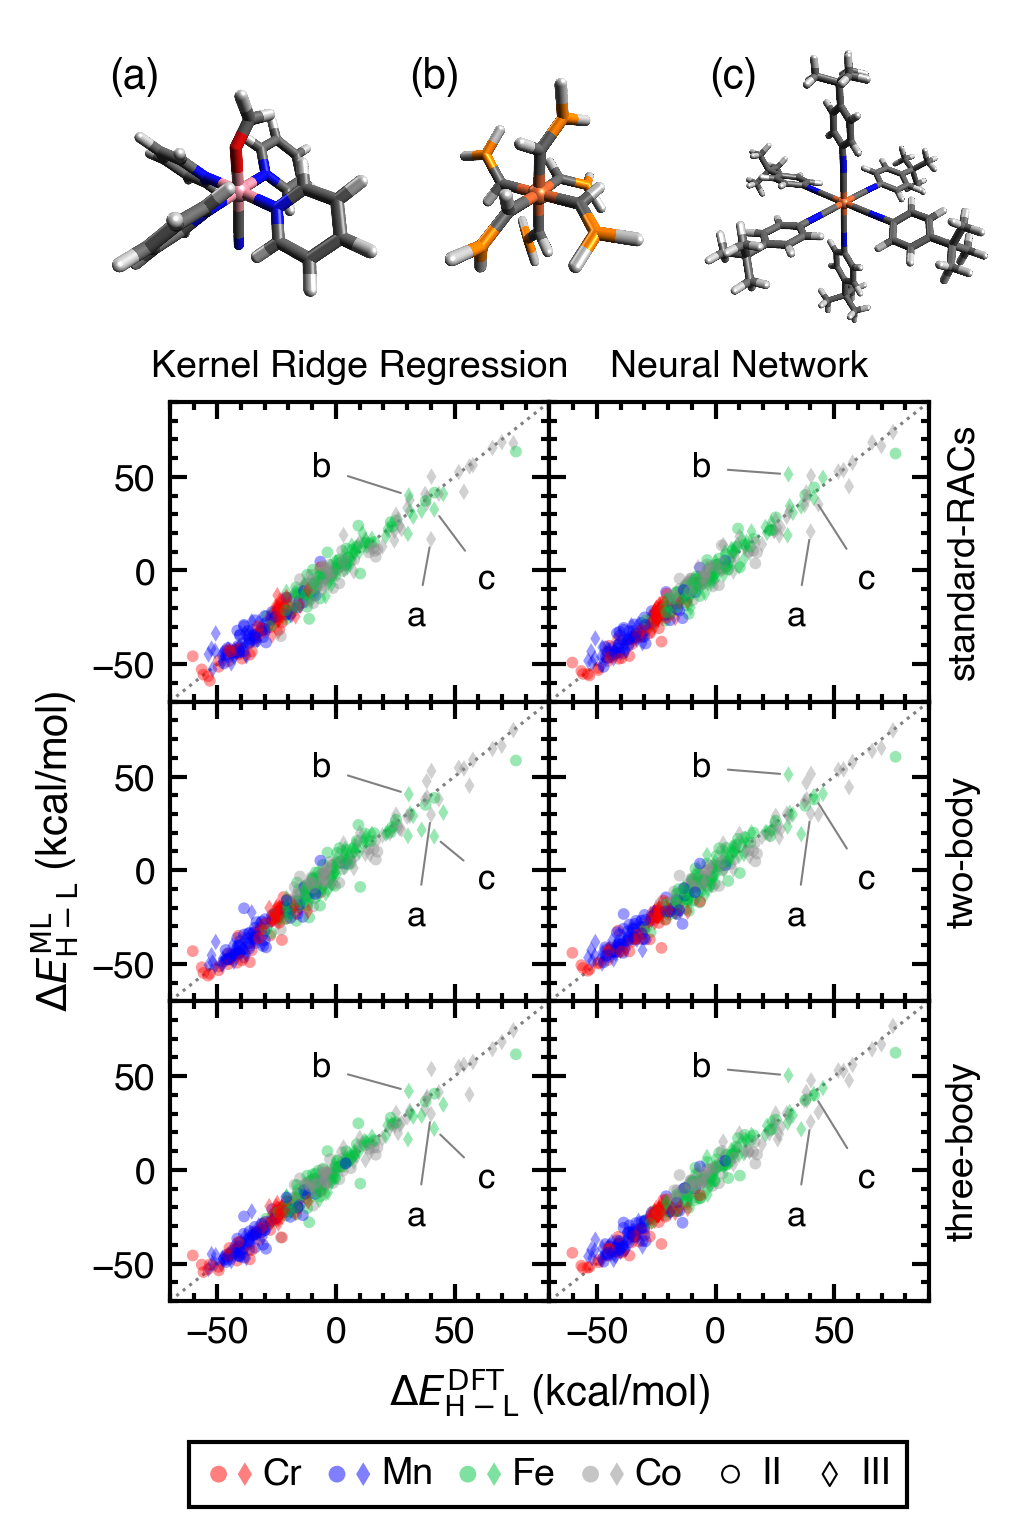

In [8]:
_, y_val = data_prep(df_val, LigandFeatures.STANDARD_RACS, TargetProperty.SSE, False)
cores_val = df_val[["metal", "ox"]].apply(lambda x: f"{x.metal}{x.ox}", axis=1).values

figsize = (3.33, 1.5 * 3.33)
fig = plt.figure(figsize=figsize)
gridspec_kw = {
    "left": 0.16,
    "right": 0.92,
    "top": 0.75,
    "bottom": 0.15,
    "hspace": 0.0,
    "wspace": 0.0,
}
axes = fig.subplots(
    ncols=2,
    nrows=3,
    sharex=True,
    sharey=True,
    gridspec_kw=gridspec_kw,
)

scatter_kwargs = {"s": 8, "alpha": 0.4, "edgecolors": "none"}
lower_lim = -70
upper_lim = 90

for experiment, ax in zip(experiments, axes.T.flatten()):
    colors = np.array([color_dict[core[:2]] for core in cores_val])
    markers = np.array([marker_dict[core[-1]] for core in cores_val])
    scatter_random_z(
        ax,
        y_val,
        experiment.prediction_val,
        colors,
        markers,
        **scatter_kwargs,
    )
    # Plot parity line:
    ax.plot(
        [lower_lim, upper_lim],
        [lower_lim, upper_lim],
        color="0.5",
        linewidth=0.75,
        zorder=0.5,
        linestyle=":",
    )
    # Set limits and ticks
    ax.set_xlim([lower_lim, upper_lim])
    ax.set_ylim([lower_lim, upper_lim])
    ax.set_xticks(10 * np.arange(-7, 10), minor=True)
    ax.set_yticks(10 * np.arange(-7, 10), minor=True)

fig.text(
    gridspec_kw["left"] + 0.5 * (gridspec_kw["right"] - gridspec_kw["left"]),
    gridspec_kw["bottom"] - 0.07,
    "$\Delta E^\mathrm{DFT}_{\mathrm{H}-\mathrm{L}}$ (kcal/mol)",
    ha="center",
)
fig.text(
    0.02,
    gridspec_kw["bottom"] + 0.5 * (gridspec_kw["top"] - gridspec_kw["bottom"]),
    "$\Delta E^\mathrm{ML}_{\mathrm{H}-\mathrm{L}}$ (kcal/mol)",
    rotation=90,
    va="center",
)
title_y = None
axes[0, 0].set_title("Kernel Ridge Regression", fontsize=9, y=title_y)
axes[0, 1].set_title("Neural Network", fontsize=9, y=title_y)
for i, label in enumerate(["standard-RACs", "two-body", "three-body"]):
    axes[i, 1].set_ylabel(label, fontsize=9)
    axes[i, 1].yaxis.set_label_position("right")

# Legend
core_legend(
    axes[-1, 1],
    legend_kwargs=dict(
        loc="lower left",
        bbox_to_anchor=[-1.0, -0.75],
        markerscale=0.9,
        handletextpad=0.08,
        columnspacing=0.52,
    ),
)

annotations = [
    (251, "a", (30, -30)),
    (51, "b", (-10, 50)),
    (352, "c", (60, -10)),
]
for experiment, ax in zip(experiments, axes.T.flatten()):
    for ind, s, xytext in annotations:
        ax.annotate(
            s,
            xy=(y_val[ind], experiment.prediction_val[ind]),
            xytext=xytext,
            fontsize="small",
            arrowprops=dict(arrowstyle="-", linewidth=0.5, color="0.5"),
        )

inset_size = (1,)
insets = [
    ("a", "plots/co_3_pyr_pyr_pyr_pyr_cyanide_formaldehyde_LS.png", 0.062, 0.5),
    (
        "b",
        "plots/fe_3_[CH+]=[PH2-]_[CH+]=[PH2-]_[CH+]=[PH2-]_[CH+]=[PH2-]_[CH+]=[PH2-]_[CH+]=[PH2-]_LS.png",
        0.044,
        0.55,
    ),
    ("c", "plots/fe_3_pisc_pisc_pisc_pisc_pisc_pisc_LS.png", 0.063, 0.51),
]
x_offset = 0.28
y_offset = -1.05
for i, (s, path, scale, y) in enumerate(insets):
    ax = fig.add_axes(
        (
            (i + x_offset) / figsize[0],
            (figsize[1] + y_offset) / figsize[1],
            1 / figsize[0],
            1 / figsize[1],
        )
    )
    ax.text(0.05, 0.95, f"({s})", fontsize="medium", ha="left", va="top")
    im = mpimg.imread(path)
    imagebox = OffsetImage(im, zoom=scale)
    ab = AnnotationBbox(imagebox, (0.5, y), frameon=False)
    ax.add_artist(ab)
    ax.set_axis_off()


fig.savefig("plots/parity_plot_sse_val.pdf", dpi=400)

# Distribution of errors

In [9]:
from matplotlib.legend_handler import HandlerTuple

alpha_dict = {"2": 0.6, "3": 1.0}


def core_legend_hist(ax, legend_kwargs=None):
    if legend_kwargs is None:
        legend_kwargs = dict(loc="upper left")

    handles = []
    labels = []
    for metal, color in color_dict.items():
        handles.append(
            (
                ax.hist([], color=color, alpha=alpha_dict["2"])[2],
                ax.hist([], color=color, alpha=alpha_dict["3"])[2],
            )
        )
        labels.append(metal.capitalize())
    for ox, alpha in [("II", alpha_dict["2"]), ("III", alpha_dict["3"])]:
        handles.append(
            tuple(
                (
                    ax.hist([], color=color, alpha=alpha)[2]
                    for color in color_dict.values()
                )
            )
        )
        labels.append(ox)

    legend = ax.legend(
        handles,
        labels,
        ncols=6,
        handler_map={tuple: HandlerTuple(ndivide=None, pad=0.0)},
        **legend_kwargs,
    )
    return legend

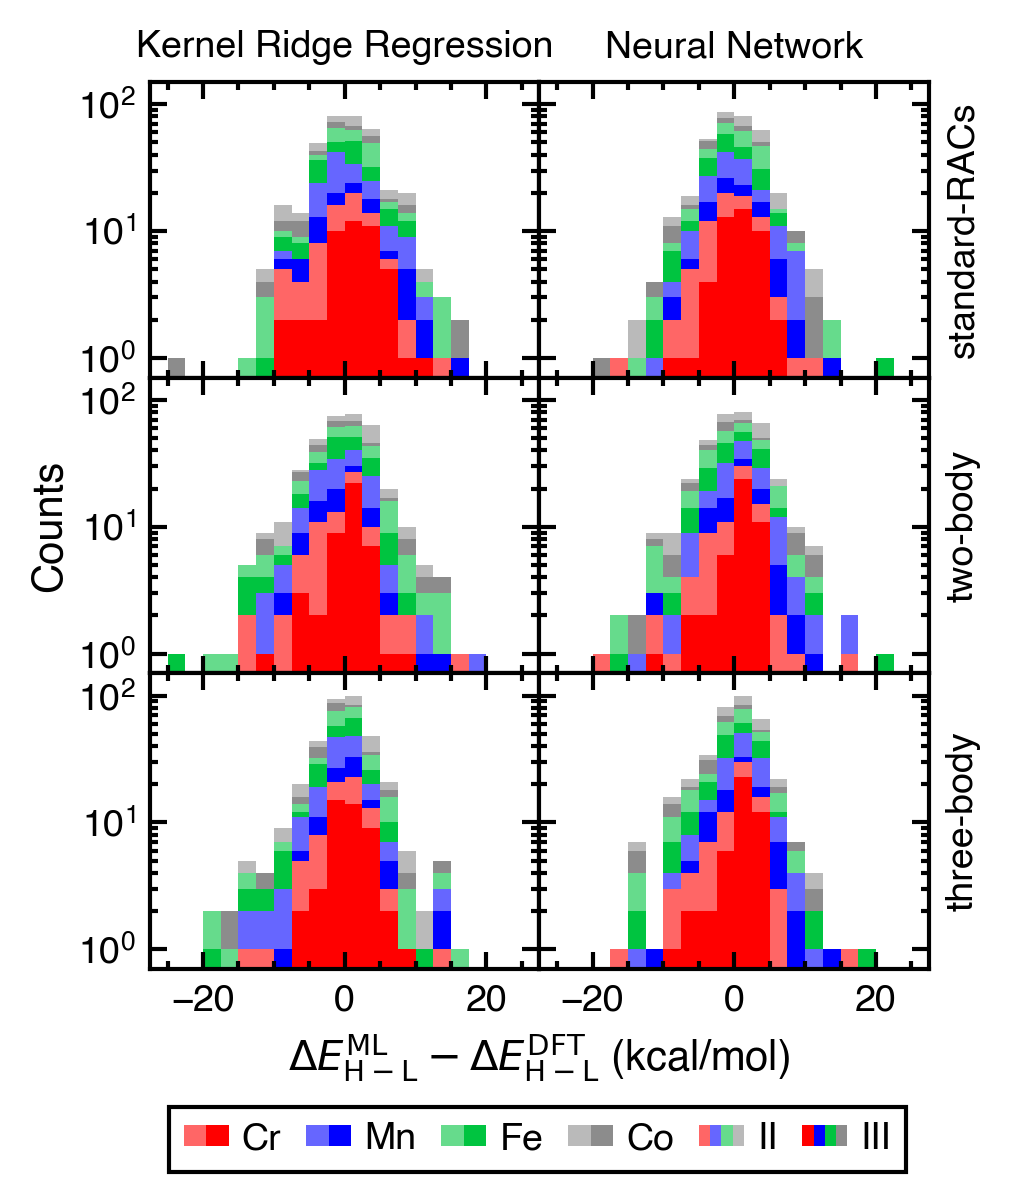

In [10]:
unique_cores = ["cr3", "cr2", "mn3", "mn2", "fe3", "fe2", "co3", "co2"]
bins = np.linspace(-25, 25, 21)

gridspec_kw = {
    "left": 0.14,
    "right": 0.92,
    "top": 0.93,
    "bottom": 0.19,
    "hspace": 0.0,
    "wspace": 0.0,
}
fig, axes = plt.subplots(
    figsize=(3.33, 1.2 * 3.33),
    ncols=2,
    nrows=3,
    sharex=True,
    sharey=True,
    gridspec_kw=gridspec_kw,
)

for experiment, ax in zip(experiments, axes.T.flatten()):
    bottom = np.zeros(len(bins) - 1)
    for core in unique_cores:
        mask = cores_val == core
        counts, _, _ = ax.hist(
            experiment.prediction_val.flatten()[mask] - y_val.flatten()[mask],
            bins=bins,
            bottom=bottom,
            color=color_dict[core[:2]],
            alpha=alpha_dict[core[-1]],
        )
        bottom += counts
    ax.set_yscale("log")
    ax.set_ylim(0.7, 150)
    ax.set_xticks(5 * np.arange(-5, 6), minor=True)
    ax.set_yticks(
        list(range(2, 10)) + [10 * i for i in range(2, 10)],
        minor=True,
    )

fig.text(
    gridspec_kw["left"] + 0.5 * (gridspec_kw["right"] - gridspec_kw["left"]),
    gridspec_kw["bottom"] - 0.085,
    "$\Delta E^{\mathrm{ML}}_{\mathrm{H}-\mathrm{L}} - \Delta E^{\mathrm{DFT}}_{\mathrm{H}-\mathrm{L}}$ (kcal/mol)",
    ha="center",
)
fig.text(
    0.02,
    gridspec_kw["bottom"] + 0.5 * (gridspec_kw["top"] - gridspec_kw["bottom"]),
    "Counts",
    va="center",
    rotation=90,
)
axes[0, 0].set_title("Kernel Ridge Regression", fontsize=9)
axes[0, 1].set_title("Neural Network", fontsize=9)
for i, label in enumerate(["standard-RACs", "two-body", "three-body"]):
    axes[i, 1].set_ylabel(label, fontsize=9)
    axes[i, 1].yaxis.set_label_position("right")

core_legend_hist(
    axes[-1, 1],
    legend_kwargs=dict(
        loc="lower left",
        bbox_to_anchor=[-1.0, -0.75],
        handlelength=1.2,
        handleheight=0.5,
        handletextpad=0.35,
        columnspacing=0.66,
    ),
)
fig.savefig("plots/residual_histogram_sse_val.pdf")

# Analyze outliers on the validation set

In [11]:
for experiment in experiments:
    print(f"Largest outliers 3 for {experiment.name}:")
    inds = np.argsort(abs(experiment.prediction_val.flatten() - y_val.flatten()))
    for ind in reversed(inds[-3:]):
        print(
            ind, df_val.iloc[ind]["name"], experiment.prediction_val[ind], y_val[ind, 0]
        )

Largest outliers 3 for krr_standard_racs:
251 co_3_pyr_pyr_pyr_pyr_cyanide_formaldehyde 16.687663573081352 40.092788681875085
281 mn_3_ammonia_ammonia_ammonia_ammonia_carbonyl_carbonyl -33.615898682511904 -50.67345954284657
249 co_3_hydrogensulfide_hydrogensulfide_hydrogensulfide_hydrogensulfide_[OH-]_phosphine 18.862053996178474 3.1962582226243117
Largest outliers 3 for krr_two_body:
352 fe_3_pisc_pisc_pisc_pisc_pisc_pisc 18.013313304757006 41.42241091309083
9 fe_2_[S]=[CH]-[CH]=[S]_[S]=[CH]-[CH]=[S]_[S]=[CH]-[CH]=[S]_[S]=[CH]-[CH]=[S]_[S]=[CH]-[CH]=[S]_[S]=[CH]-[CH]=[S] -8.959418175889734 10.261645734762528
62 mn_2_[N]#[N]_[N]#[N]_[N]#[N]_[N]#[N]_[N]#[N]_[N]#[N] -20.35991364993844 -38.746798493356295
Largest outliers 3 for krr_three_body:
352 fe_3_pisc_pisc_pisc_pisc_pisc_pisc 21.954645923892357 41.42241091309083
9 fe_2_[S]=[CH]-[CH]=[S]_[S]=[CH]-[CH]=[S]_[S]=[CH]-[CH]=[S]_[S]=[CH]-[CH]=[S]_[S]=[CH]-[CH]=[S]_[S]=[CH]-[CH]=[S] -7.339596844924208 10.261645734762528
46 fe_2_[O]=[PH]_[O]

32.583613932144125 [41.42241091]
211 mn_2_pisc_pisc_pisc_pisc_pisc_pisc 101.34680738594429 14.706741560165357
1394 fe_2_pisc_pisc_pisc_pisc_pisc_pisc 97.55087940376482 43.39630709870831
222 mn_3_ox_ox_ox_ox_pisc_pisc 85.28062510762865 -40.55263452682472


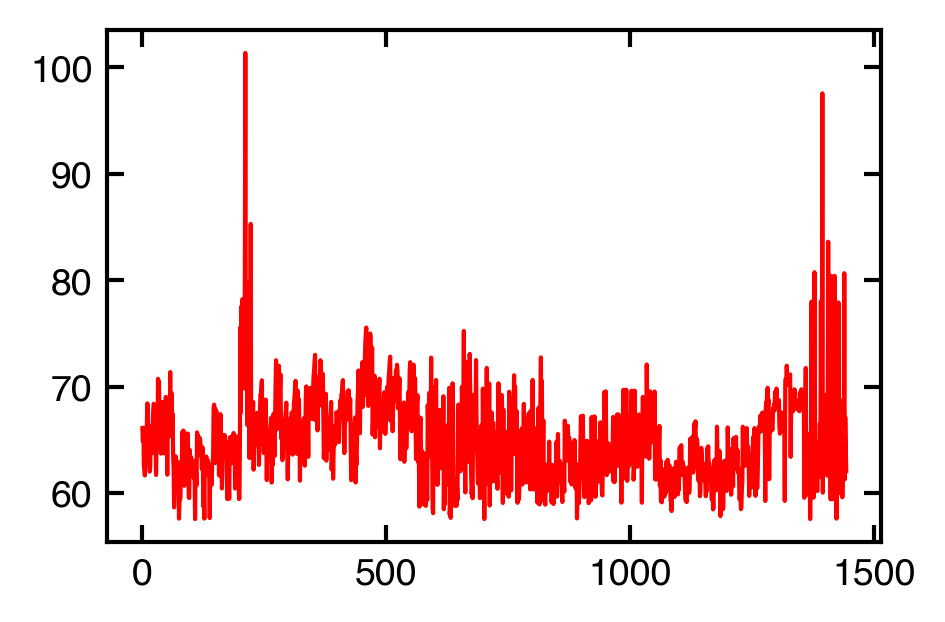

In [12]:
# Analyse KRR standard RACs
multiply_by_K_train = False
outlier_ind = 352
experiment = experiments[0]
print(experiment.prediction_val[outlier_ind], y_val[outlier_ind])
with open(
    model_dir / experiment.target.name.lower() / f"{experiment.name}.pkl",
    "rb",
) as fin:
    model = pickle.load(fin)
    gpr = model.named_steps["gpr"]
x_val, _ = data_prep(df_val, experiment.features, experiment.target, experiment.is_nn)
weights = gpr.kernel_(
    gpr.X_train_,
    model.named_steps["input_scaler"].transform(x_val[outlier_ind].reshape(1, -1)),
)
if multiply_by_K_train:
    K = gpr.kernel_(gpr.X_train_)
    K[np.diag_indices_from(K)] += gpr.alpha
    weights = np.linalg.pinv(K) @ weights

plt.plot(weights)
inds = np.argsort(abs(weights.flatten()))[::-1][:3]
for ind in inds:
    print(
        ind,
        df_train.iloc[ind]["name"],
        weights[ind][0],
        df_train.iloc[ind][experiment.target.full_name()[0]],
    )

18.013313304757006 [41.42241091]
146 fe_3_hydrogenisocyanide_hydrogenisocyanide_hydrogenisocyanide_hydrogenisocyanide_hydrogenisocyanide_hydrogenisocyanide 171.1761632640939 36.51383269964139
456 fe_3_misc_misc_misc_misc_misc_misc 168.25276946744313 37.27680094942277
455 fe_3_misc_misc_misc_misc_carbonyl_misc 168.02249420285935 35.205561666391446


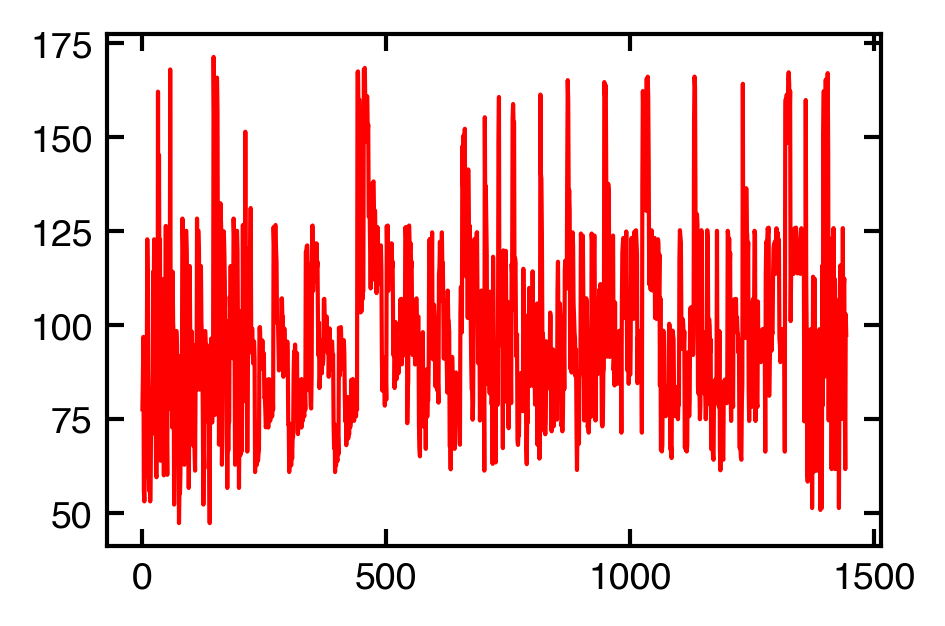

In [13]:
# Analyse two body KRR
multiply_by_K_train = False
outlier_ind = 352
experiment = experiments[1]
print(experiment.prediction_val[outlier_ind], y_val[outlier_ind])
with open(
    model_dir / experiment.target.name.lower() / f"{experiment.name}.pkl",
    "rb",
) as fin:
    model = pickle.load(fin)
    gpr = model.named_steps["gpr"]
x_val, _ = data_prep(df_val, experiment.features, experiment.target, experiment.is_nn)
weights = gpr.kernel_(
    gpr.X_train_,
    model.named_steps["input_scaler"].transform(x_val[outlier_ind].reshape(1, -1)),
)
if multiply_by_K_train:
    K = gpr.kernel_(gpr.X_train_)
    K[np.diag_indices_from(K)] += gpr.alpha
    weights = np.linalg.pinv(K) @ weights

plt.plot(weights)
inds = np.argsort(abs(weights.flatten()))[::-1][:3]
for ind in inds:
    print(
        ind,
        df_train.iloc[ind]["name"],
        weights[ind][0],
        df_train.iloc[ind][experiment.target.full_name()[0]],
    )

# Analyze outliers on the training set

In [18]:
for experiment in experiments:
    print(f"Largest outliers 3 for {experiment.name}:")
    inds = np.argsort(abs(experiment.prediction_train.flatten() - y_train.flatten()))
    for ind in reversed(inds[-3:]):
        print(
            ind,
            df_train.iloc[ind]["name"],
            experiment.prediction_train[ind],
            y_train[ind, 0],
        )

Largest outliers 3 for krr_standard_racs:
1424 cr_2_carbonyl_carbonyl_carbonyl_carbonyl_carbonyl_carbonyl -23.782638236643532 -31.283549392456234
129 fe_2_[N]#[N]_[N]#[N]_[N]#[N]_[N]#[N]_[N]#[N]_[N]#[N] -11.87177856657578 -17.50295828897704
122 fe_2_[C+]#[S-]_[C+]#[S-]_[C+]#[S-]_[C+]#[S-]_[C+]#[S-]_[C+]#[S-] 58.67572133635752 63.978732739205725
Largest outliers 3 for krr_two_body:
1424 cr_2_carbonyl_carbonyl_carbonyl_carbonyl_carbonyl_carbonyl -13.928430600473042 -31.283549392456234
864 fe_2_carbonyl_carbonyl_carbonyl_carbonyl_fluoride_fluoride 9.055979320289593 -7.028170615533963
751 fe_2_ammonia_ammonia_ammonia_ammonia_carbonyl_fluoride -5.503768298119483 9.018693731429584
Largest outliers 3 for krr_three_body:
339 cr_3_carbonyl_carbonyl_carbonyl_carbonyl_water_pyr -19.308360638930395 -9.97194494204155
1424 cr_2_carbonyl_carbonyl_carbonyl_carbonyl_carbonyl_carbonyl -22.383751588893418 -31.283549392456234
1274 co_2_misc_misc_misc_misc_misc_cyanide 18.243044526155437 9.997535343079004
